### importing data and libraries

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set_context('notebook')
import pystan 
import stan_utility
import arviz as az
import patsy
import os
import warnings 
import xarray as xr
from scipy.special import expit
from random import sample

warnings.simplefilter('ignore')#removes deprecation warnings
plt.style.use('seaborn-ticks')

order = ["Accuracy","Speed"]

LMEdata = pd.read_csv('MixedModels/LMEdata.csv')
GLMEdata = pd.read_csv('MixedModels/GLMEdata.csv')

Inversing log trans

In [44]:
LMEdata['mt'] = np.exp(LMEdata.logmt)
LMEdata['rt'] = np.exp(LMEdata.logrt)

## Note on data trimming


In [2]:
data = pd.read_csv('../Markers/MRK_ForceEMG.csv')

Amount and proportion of trials with RT > 1500 ms (flagged as No Response trials or "NR")

In [3]:
print(len(data[data.trialType == "NR"].trial))
print(len(data[data.trialType == "NR"].trial)/len(data.trial) )

400
0.01041612416019999


Amout and proportion of trials not marked because of EMG noise (flagged as Unmarked Trials or "UT")

In [4]:
print(len(data[data.trialType == "UT"].trial))
print(len(data[data.trialType == "UT"].trial)/len(data.trial))

2761
0.07189729701578043


Amout and proportion of trials with multiple EMG activities (flagged "MA")

In [5]:
print(len(data[data.trialType == "MA"].trial))
print(len(data[data.trialType == "MA"].trial)/len(data.trial))

8105
0.21105671579605229


Additional removal by fast guess criterion (performed with the same parameters in code HDDMdata_preparation.py and data_preparation_G-LME.py)

In [6]:
fast_guess_cesored_data = pd.read_csv('DDM/dataHDDM_rt.csv')

In [7]:
print(len(data[data.trialType == "SA"].participant) - len(fast_guess_cesored_data.participant))
print((len(data[data.trialType == "SA"].participant) - len(fast_guess_cesored_data.participant))/len(data.participant))

2901
0.07554294047185042


Total removal for all analysis

In [8]:
print(len(data.participant) - len(fast_guess_cesored_data.participant))
print((len(data.participant) - len(fast_guess_cesored_data.participant))/len(data.participant))

14192
0.3695640852038956


Additional removal of errors for the LMM

In [9]:
print(len(fast_guess_cesored_data.participant) - len(LMEdata.participant))
print((len(fast_guess_cesored_data.participant) - len(LMEdata.participant))/len(data.participant))

5021
0.13074839852091036


## Note on factor coding and mixed models equation

Designed mixed model for latencies and proportion of correct responses : 
\begin{equation*}
y \sim SAT + FC + Amp.  + SAT:FC + SAT:Amp. + FC:Amp. + SAT:FC:Amp.
\end{equation*}
Notes on contrast coding : 
\begin{equation*}
SAT = \begin{pmatrix} 0 & Accuracy \\ 1 & Speed \end{pmatrix}
\end{equation*}
\begin{equation*}
FC = \begin{pmatrix} -0.5 & Weak \\ 0.5 & Strong \end{pmatrix}
\end{equation*}

\begin{equation*}
Amp. = \begin{pmatrix} -.5 & -.3 & -.1 & .1 & .3 & .5 \end{pmatrix} 
\end{equation*}

# Behavioral/EMG results

In [29]:
Precision_fit = az.from_netcdf('MixedModels/FittedModels/Precision_fit.nc')
RT_fit = az.from_netcdf('MixedModels/FittedModels/RT_fit.nc')
PMT_fit = az.from_netcdf('MixedModels/FittedModels/PMT_fit.nc')
MT_fit = az.from_netcdf('MixedModels/FittedModels/MT_fit.nc')

### Coding of effects in accuracy vs speed

In [3]:

data = np.random.rand(6, 1000)
chains = np.arange(6)
samples = np.arange(1000)

trans = [expit, np.exp, np.exp, np.exp]

ms_effects = []
i = 0
for fit in [Precision_fit.posterior, RT_fit.posterior, PMT_fit.posterior, MT_fit.posterior]:
    t = trans[i]
    intercept, bSAT, bFC, bcontrast, bSATFC, bSATcontrast, bFCcontrast, bSATFCcontrast = fit.alpha.data, fit.beta.sel(beta_dim_0=0).data,fit.beta.sel(beta_dim_0=1).data,fit.beta.sel(beta_dim_0=2).data,fit.beta.sel(beta_dim_0=3).data,fit.beta.sel(beta_dim_0=4).data,fit.beta.sel(beta_dim_0=5).data,fit.beta.sel(beta_dim_0=6).data
    bSATs = t(intercept + bSAT) - t(intercept) #SAT coded as 0/1
    bFCs = (t(intercept + bFC/2) - t(intercept - bFC/2)) #FC coded as -0.5/0.5
    bCons = (t(intercept + bcontrast/2) - t(intercept - bcontrast/2))#contrast coded as -0.5,...,0.5
    
    bSATFCs = (t(intercept + bSAT + bFC/2 + bSATFC/2) - t(intercept + bSAT - bFC/2 - bSATFC/2)) 
    bSATCons = (t(intercept + bSAT + bcontrast/2 + bSATcontrast/2) - t(intercept + bSAT - bcontrast/2 - bSATcontrast/2))
    bFCCons = (t(intercept + bFC + bcontrast/2 + bFCcontrast/2) - t(intercept + bFC + bcontrast/2 - bFCcontrast/2))
    
    bSATFCCons = (t(intercept + bSAT + bFC + bSATFC + bFCcontrast + bcontrast + bSATcontrast + bFCcontrast/2 + bSATFCcontrast/2) -\
                  t(intercept + bSAT + bFC + bSATFC + bFCcontrast + bcontrast + bSATcontrast - bFCcontrast/2 - bSATFCcontrast/2))
    
    coeff_accuracy  = xr.DataArray([bFCs, bCons, bFCCons], coords=[('beta',['FC', 'Contrast', r'FC$\times$cont.']), ("chain", chains), ("draw", samples), ])
    coeff_speed  = xr.DataArray([bSATFCs, bSATCons, bSATFCCons], coords=[('beta',['FC', 'Contrast', r'FC$\times$cont.']), ("chain", chains), ("draw", samples), ])
    SAT = xr.DataArray([bSATs], coords=[('beta',['SAT']), ("chain", chains), ("draw", samples), ])
    ms_effects.append([coeff_accuracy,coeff_speed, SAT])
    i += 1
[Precision_acc, Precision_spd, Precision_SAT], [RT_acc, RT_spd, RT_SAT], [PMT_acc, PMT_spd, PMT_SAT], [MT_acc, MT_spd, MT_SAT] = ms_effects
[Precision_acc, Precision_spd, Precision_SAT], [RT_acc, RT_spd, RT_SAT], [PMT_acc, PMT_spd, PMT_SAT], [MT_acc, MT_spd, MT_SAT] = [Precision_acc.rename(""), Precision_spd.rename(""), Precision_SAT.rename("")], [RT_acc.rename(""), RT_spd.rename(""), RT_SAT.rename("")], [PMT_acc.rename(""), PMT_spd.rename(""), PMT_SAT.rename("")], [MT_acc.rename(""), MT_spd.rename(""), MT_SAT.rename("")] 

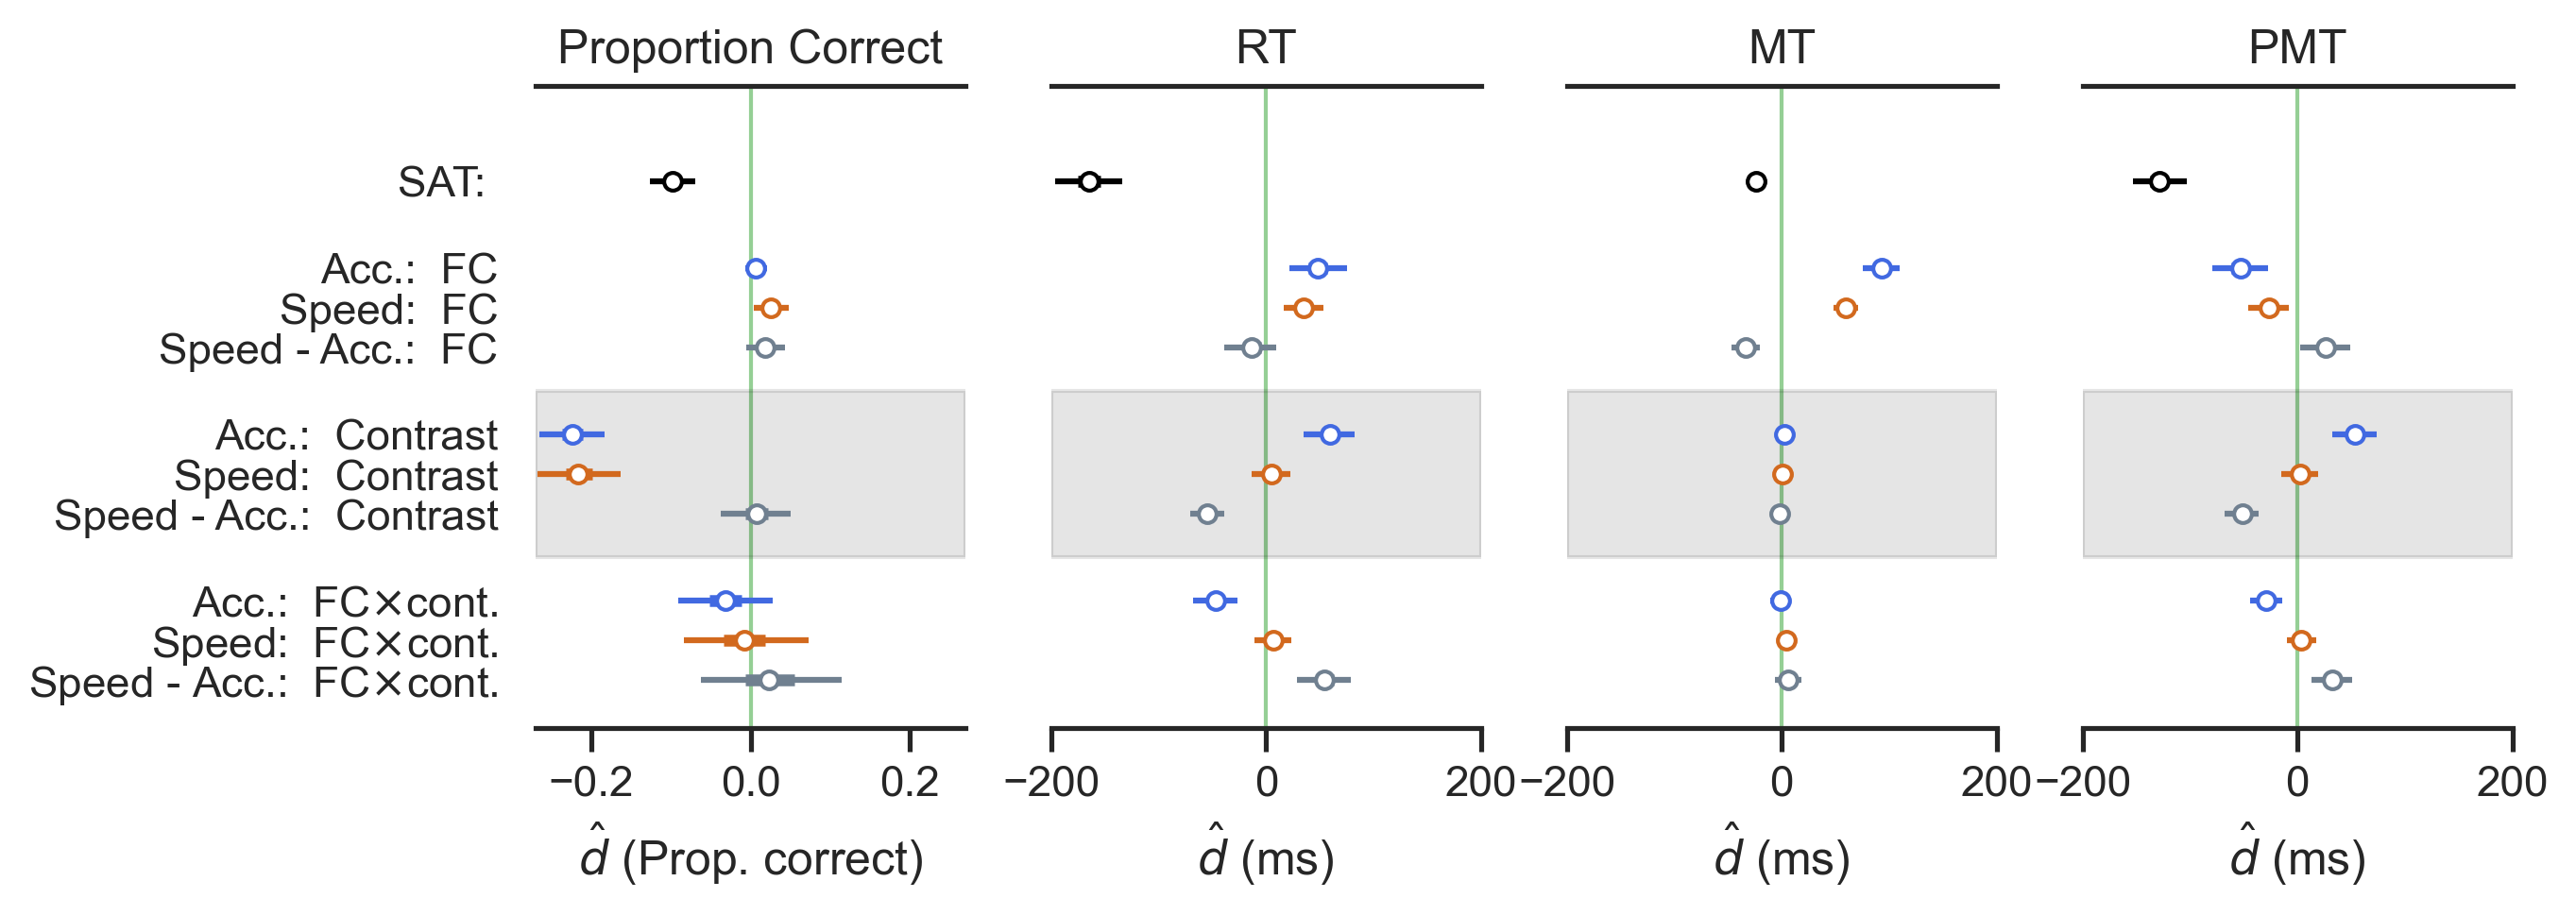

In [5]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, sharey=True, sharex=False,dpi=300, figsize=(9,3))

g = az.plot_forest([Precision_SAT.sel(beta="SAT"), Precision_acc, Precision_spd, Precision_spd-Precision_acc], model_names=['SAT','Acc.', 'Speed','Speed - Acc.'], hdi_prob=0.95, 
                   combined=True, rope=[-0,0], ax=ax0, colors=['k','royalblue','chocolate','slategray'])
g = az.plot_forest([RT_SAT.sel(beta="SAT"), RT_acc, RT_spd, RT_spd-RT_acc], model_names=['SAT','Acc.', 'Speed','Speed - Acc.'], hdi_prob=0.95, 
                   combined=True, rope=[-0,0], ax=ax1, colors=['k','royalblue','chocolate','slategray'])
g = az.plot_forest([MT_SAT.sel(beta="SAT"), MT_acc, MT_spd, MT_spd-MT_acc], model_names=['SAT','Acc.', 'Speed','Speed - Acc.'], hdi_prob=0.95, 
                   combined=True, rope=[-0,0], ax=ax2, colors=['k','royalblue','chocolate','slategray'])
g = az.plot_forest([PMT_SAT.sel(beta="SAT"), PMT_acc, PMT_spd, PMT_spd-PMT_acc], model_names=['SAT','Acc.', 'Speed','Speed - Acc.'], hdi_prob=0.95, 
                   combined=True, rope=[-0,0], ax=ax3, colors=['k','royalblue','chocolate','slategray'])
#g = az.plot_forest([RT_SAT, PMT_SAT, MT_SAT], hdi_prob=0.95, 
#                   combined=True, rope=[-0,0], ax=ax2, colors=['indianred','royalblue'])
ax0.set(title='Proportion Correct',xlim = (-.27, .27), xlabel=r'$\hat{d}$ (Prop. correct)')
ax1.set(title='RT', xlim = (-200, 200), xlabel=r'$\hat{d}$ (ms)')
ax2.set(title='MT', xlim = (-200, 200), xlabel=r'$\hat{d}$ (ms)')
ax3.set(title='PMT', xlim = (-200, 200), xlabel=r'$\hat{d}$ (ms)')
#ax2.set(title='SAT Interactions', xlabel='Effect size (log)')
plt.savefig('../LMMcoeff.png', bbox_inches='tight',dpi=300)
plt.legend()
plt.show()


Next cell I print the values of the graphic aboven, ordereding of the rows is the same as in plot : 0 = FC, 1 = contrast, 2 = FCxContrast

In [15]:
names = ["Precision_SAT", "Precision_acc", "Precision_spd", "Precision_spd - Precision_acc", "RT_SAT", "RT_acc", "RT_spd", "RT_spd - RT_acc", "PMT_SAT", "PMT_acc", "PMT_spd", "PMT_spd - PMT_acc", "MT_SAT", "MT_acc", "MT_spd", "MT_spd - MT_acc"]
i=0
for fit in [Precision_SAT, Precision_acc, Precision_spd, Precision_spd - Precision_acc, RT_SAT, RT_acc, RT_spd, RT_spd - RT_acc, PMT_SAT, PMT_acc, PMT_spd, PMT_spd - PMT_acc, MT_SAT, MT_acc, MT_spd, MT_spd - MT_acc]:
    print(names[i])
    print(az.summary(fit, hdi_prob=.95, round_to=4)[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']])
    print('________________________________________________________')
    i+= 1

Precision_SAT
       mean      sd  hdi_2.5%  hdi_97.5%
[0] -0.0985  0.0144   -0.1263     -0.069
________________________________________________________
Precision_acc
       mean      sd  hdi_2.5%  hdi_97.5%
[0]  0.0071  0.0070   -0.0067     0.0212
[1] -0.2234  0.0206   -0.2652    -0.1837
[2] -0.0313  0.0306   -0.0911     0.0284
________________________________________________________
Precision_spd
       mean      sd  hdi_2.5%  hdi_97.5%
[0]  0.0260  0.0112    0.0041     0.0480
[1] -0.2153  0.0268   -0.2677    -0.1629
[2] -0.0077  0.0394   -0.0831     0.0724
________________________________________________________
Precision_spd - Precision_acc
       mean      sd  hdi_2.5%  hdi_97.5%
[0]  0.0189  0.0123   -0.0059     0.0430
[1]  0.0081  0.0224   -0.0370     0.0507
[2]  0.0236  0.0452   -0.0619     0.1144
________________________________________________________
RT_SAT
         mean       sd  hdi_2.5%  hdi_97.5%
[0] -164.5986  15.9811 -196.8028  -134.4388
_______________________________

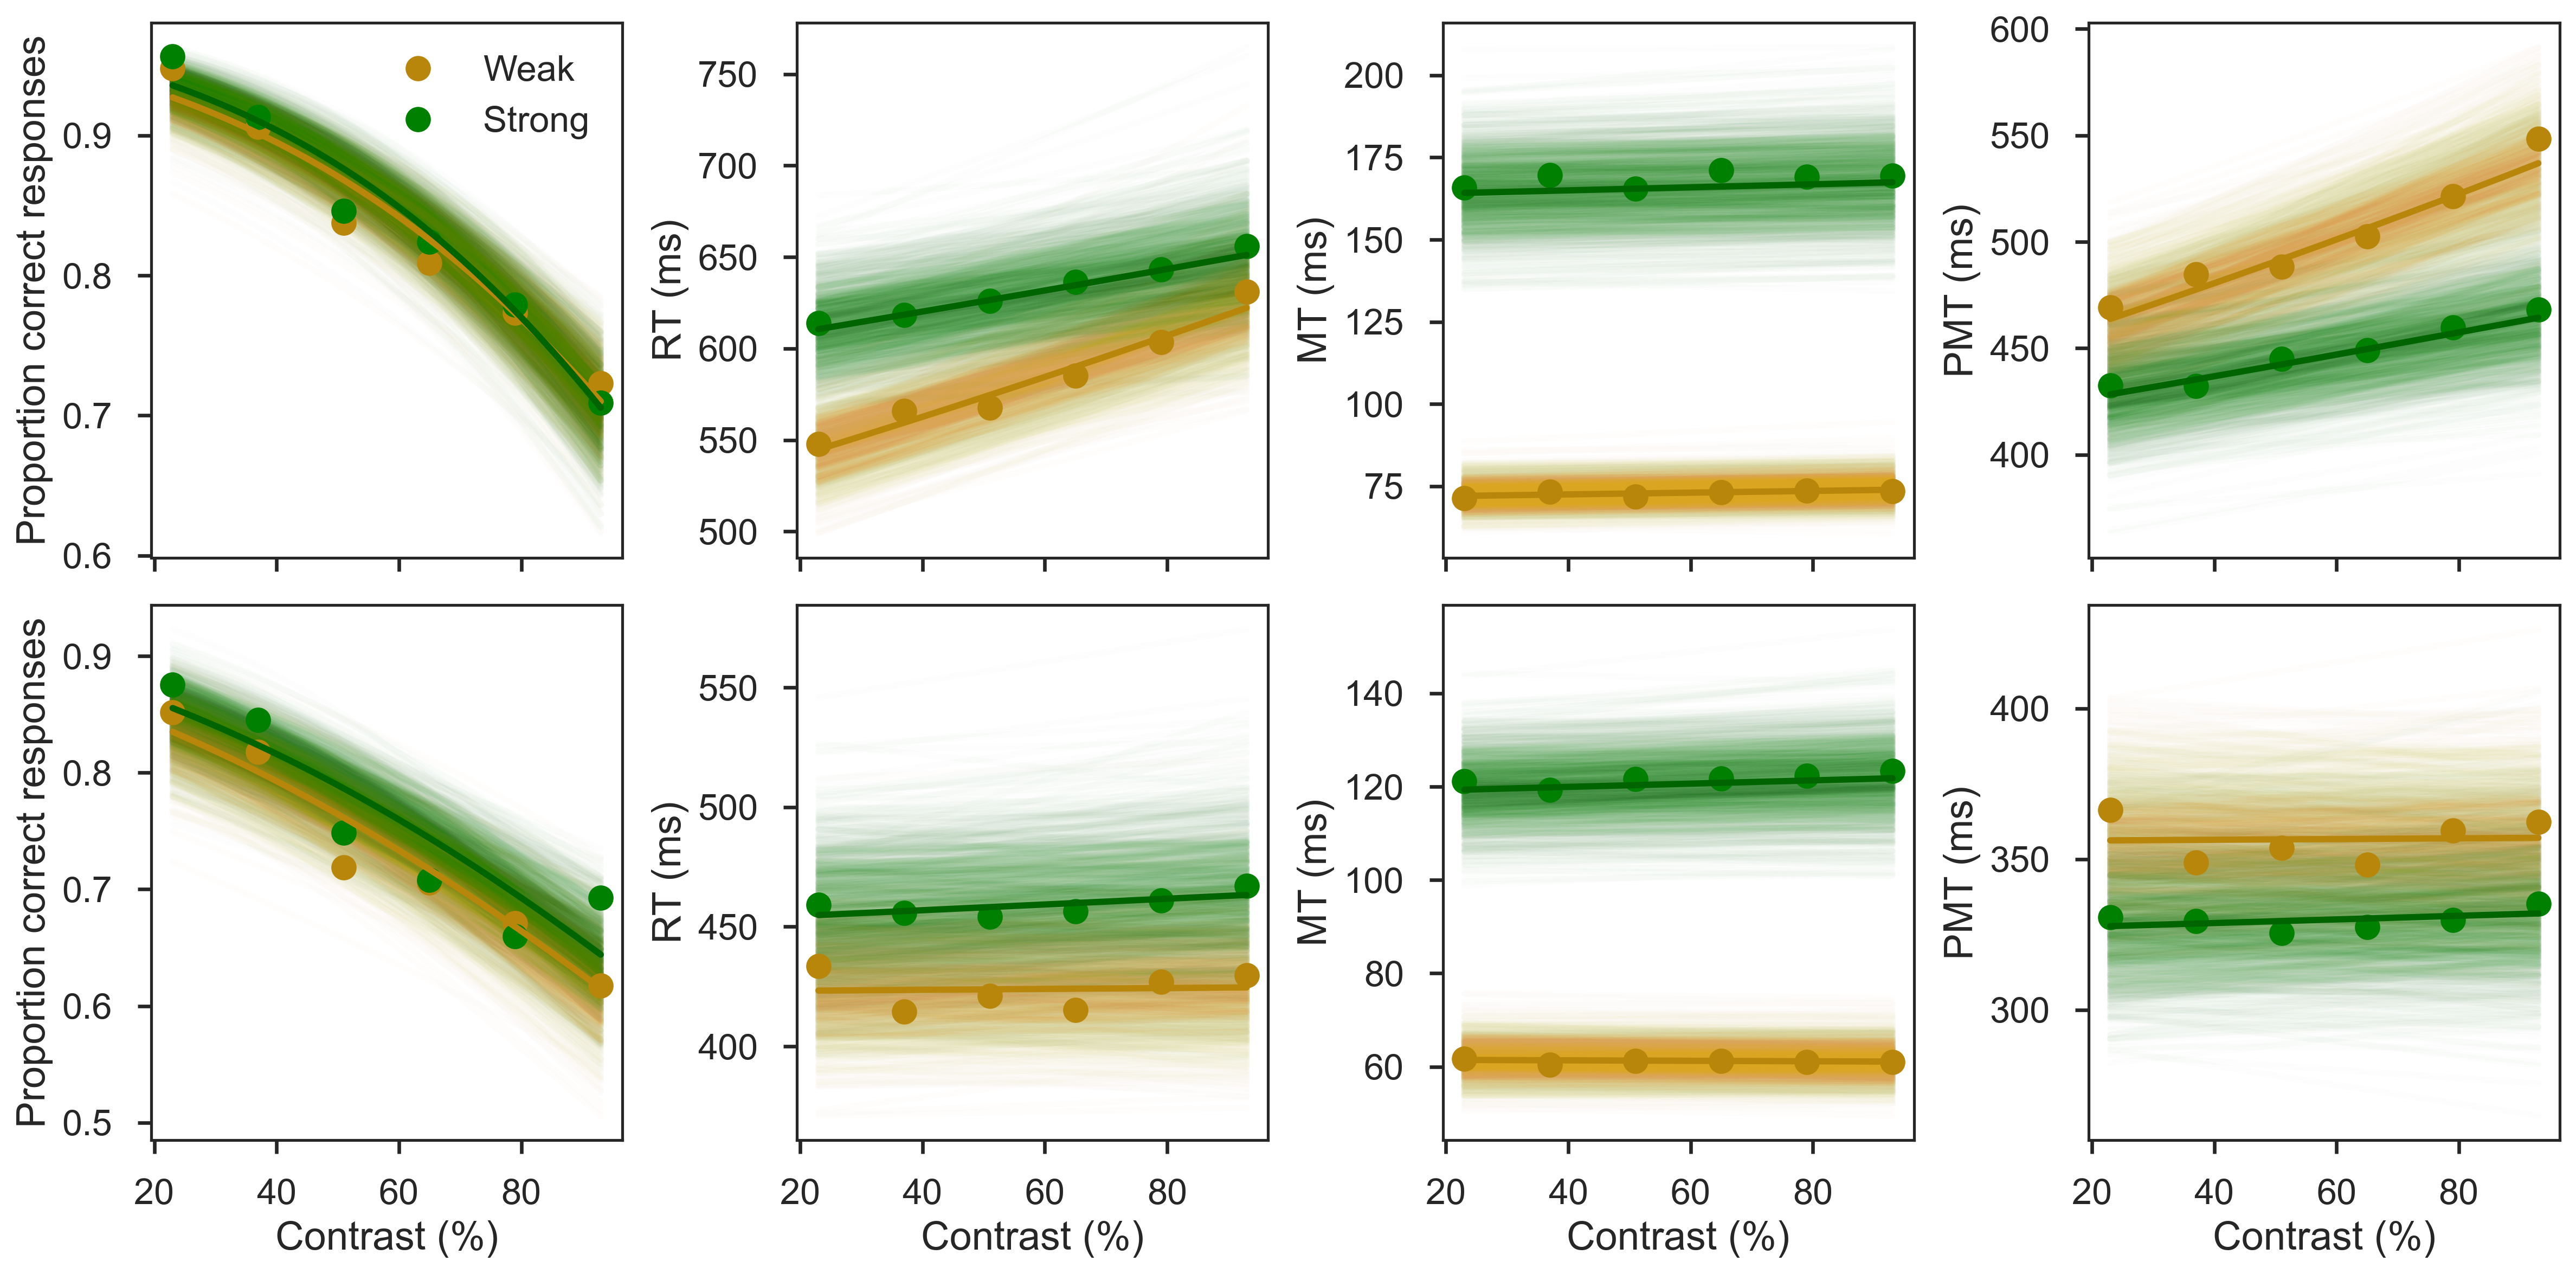

In [25]:

plt.style.use('seaborn-poster')


dv = {'response': Precision_fit, 'rt':RT_fit,'prmt':PMT_fit,'mt':MT_fit}
order = {'response': 0, 'rt':1,'prmt':3,'mt':2}
trans = {'response': expit, 'rt':np.exp,'prmt':np.exp,'mt':np.exp}
upcase = {'rt':'RT','prmt':'PMT','mt':'MT'}
chron = ["rt","prmt","mt"]
fig, ax = plt.subplots(2,4, sharey=False, figsize=(16,8), sharex=True, dpi=300)
x = np.linspace(1,6,100)
display_range = np.linspace(23,93,100)
contrast = np.linspace(LMEdata.contrast.min(),LMEdata.contrast.max(),100)
for y in dv.keys():
    fixeff_form = "1+SAT+FC+contrast+SAT:FC+SAT:contrast+FC:contrast+SAT:FC:contrast"#Fixed effects formula
    fit = dv[y]
    param_dict = {val : idx for idx, val in enumerate(fixeff_form.split('+')[1:])} 
    #fit.posterior.beta.coords['beta_dim_0'].values = fixeff_form.split('+')[1:]
    j = order[y]
    alpha, beta = fit.posterior.alpha, fit.posterior.beta
    samples,chains = fit.posterior.draw.values,fit.posterior.chain.values
    for z in np.arange(2):
        for d in sample(list(samples),1000):
            c = np.random.choice(chains)
            intercept, bSAT, bFC, bcontrast, bSATFC, bSATcontrast, bFCcontrast, bSATFCcontrast =  \
                alpha.sel(draw=d, chain=c).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["FC"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["contrast"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:FC"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:contrast"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["FC:contrast"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:FC:contrast"]).values
            ax[z, j].plot(display_range, trans[y](intercept+bSAT*z+contrast*(bcontrast+bSATcontrast*z+bFCcontrast*-0.5+bSATFCcontrast*z*-0.5)+-0.5*(bFC + bSATFC*z)), color="goldenrod", alpha=.01)
            ax[z, j].plot(display_range, trans[y](intercept+bSAT*z+contrast*(bcontrast+bSATcontrast*z+bFCcontrast*0.5+bSATFCcontrast*z*0.5)+0.5*(bFC + bSATFC*z)), color="g", alpha=.01)
        intercept, bSAT, bFC, bcontrast, bSATFC, bSATcontrast, bFCcontrast, bSATFCcontrast = \
            alpha.mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["FC"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["contrast"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["SAT:FC"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT:contrast"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["FC:contrast"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT:FC:contrast"]).mean(axis=(0,1)).values
        if y in chron:
            ax[z, j].set_ylabel('%s (ms)' %upcase[y])
            dy = 'log' + y
            data = LMEdata
        else :
            ax[z, j].set_ylabel('Proportion correct responses')
            data = GLMEdata
            dy = y
        F1 = data[(data.SAT==z) & (data.FC==-0.5)].groupby(['participant','contrast']).mean().groupby('contrast') #Strong force only
        F2 = data[(data.SAT==z) & (data.FC==0.5)].groupby(['participant','contrast']).mean().groupby('contrast') #Strong force only
        if 'log' in dy:
            ax[z, j].plot(np.linspace(23,93,6), np.exp(F1[dy].mean().values),'o',markerfacecolor="darkgoldenrod", markeredgecolor ="k", label="Weak")
            ax[z, j].plot(np.linspace(23,93,6), np.exp(F2[dy].mean().values),'o',markerfacecolor="g", markeredgecolor ="k", label="Strong")
        else : 
            ax[z, j].plot(np.linspace(23,93,6), F1[dy].mean().values,'o',markerfacecolor="darkgoldenrod", markeredgecolor ="k", label="Weak")
            ax[z, j].plot(np.linspace(23,93,6), F2[dy].mean().values,'o',markerfacecolor="g", markeredgecolor ="k", label="Strong")
        ax[z, j].plot(display_range, trans[y](intercept+bSAT*z+contrast*(bcontrast+bSATcontrast*z+bFCcontrast*-0.5+bSATFCcontrast*z*-0.5)+-0.5*(bFC + bSATFC*z)), color="darkgoldenrod")
        ax[z, j].plot(display_range, trans[y](intercept+bSAT*z+contrast*(bcontrast+bSATcontrast*z+bFCcontrast*0.5+bSATFCcontrast*z*0.5)+0.5*(bFC + bSATFC*z)), color="darkgreen")
        if z == 1:
            ax[z, j].set_xlabel('Contrast (%)')
        if j == 0 and z == 0:
            ax[z, j].legend(loc=1)
plt.tight_layout()
plt.show()